In [1]:
#!/usr/bin/env python3
# Copyright 2004-present Facebook. All Rights Reserved.
#  python optim.py -s example1/synth_test.json -e example1
import argparse
import json
import logging
import os
import random
import time
import torch
import numpy as np

import deep_sdf
import deep_sdf.workspace as ws

import pdb

from library.optimiser import *
from library.objective_function import *
from library.post_analysis import *
from library.experiments import *
from deep_sdf.mesh import create_mesh_optim

%matplotlib inline

In [2]:
def adjust_learning_rate(initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every):
    lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def chamfer_distance(p1, p2):
    '''
    Calculate Chamfer Distance between two point sets
    '''
    p1 = p1.unsqueeze(0)
    p2 = p2.unsqueeze(0)

    p1 = p1.repeat(p2.size(1), 1, 1)
    p1 = p1.transpose(0, 1)

    p2 = p2.repeat(p1.size(0), 1, 1)

    # compute distance tensor
    dist = torch.add(p1, torch.neg(p2))
    dist = torch.norm(dist, 2, dim=2)

    dist1, _ = torch.min(dist, dim = 1)
    dist2, _ = torch.min(dist, dim = 0)

    return torch.mean(dist1) + torch.mean(dist2)

class argms:
    def __init__(self):
        self.experiment_directory = "example1"
        self.checkpoint = "latest"
        self.iterations = 100
        self.split_filename = "example1/synth_test.json"
        self.logfile = None
        self.debug = False
        self.quiet = False
args = argms()

def getLatentSourceAndTarget(args, source_id, target_id):
    # pick initialization and samples
    # Load collection of all latent codes
    all_codes_path = os.path.join(
        args.experiment_directory,
        ws.latent_codes_subdir,
        'latest.pth')
    all_codes = torch.load(all_codes_path)['latent_codes']['weight']
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    latent = all_codes[source_id].unsqueeze(0).detach().cuda()   #Add .cuda() if you want to run on GPU
    latent.requires_grad = True

    # This is be the target shape (ie objective)
    latent_target = all_codes[target_id].unsqueeze(0).detach().cuda()   #Add .cuda() if you want to run on GPU
    return latent, latent_target

def constructDecoder(args):
    specs_filename = os.path.join(args.experiment_directory, "specs.json")
    specs = json.load(open(specs_filename))
    arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])
    latent_size = specs["CodeLength"]
    # Load decoder: this is our black box function
    decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])
    decoder = torch.nn.DataParallel(decoder)
    saved_model_state = torch.load(
        os.path.join(
            args.experiment_directory, ws.model_params_subdir, args.checkpoint + ".pth"
        ),
       # map_location=torch.device('cpu') # Remove this if you want to run on GPU
    )
    decoder.load_state_dict(saved_model_state["model_state_dict"])
    # Optionally: put decoder on GPU
    decoder = decoder.module.cuda()
    return decoder

class decoder_obj(objective_func):
    def __init__(self, latent_target, decoder):
        self.N_MARCHING_CUBE = 64
        self.l2reg= True
        self.regl2 = 1e-3
        self.iter = 0
        self.quick = True
        
        self.latent_target = latent_target
        self.decoder = decoder
        self.optimum = 0
        self.optimal = latent_target
        
        # Get a mesh representation of the target shape
        self.verts_target, faces_target = create_mesh_optim(
            decoder, latent_target, N=self.N_MARCHING_CUBE, max_batch=int(2 ** 18)
        )
    
        
    def func(self, latent):
        # from latent to xyz
        verts, faces = deep_sdf.mesh.create_mesh_optim(self.decoder, latent, N=self.N_MARCHING_CUBE, max_batch=int(2 ** 18))
        verts = verts[torch.randperm(verts.shape[0])]
        verts = verts[0:20000, :]
        self.xyz_upstream = torch.tensor(verts.astype(float), requires_grad = True, dtype=torch.float32,device=torch.device('cuda:0') )#, ) # For GPU,
       
        # from latent_traget to xyz_target
        verts_target_sample = self.verts_target[torch.randperm(self.verts_target.shape[0])]
        verts_target_sample = verts_target_sample[0:20000, :]
        xyz_target = torch.tensor(verts_target_sample.astype(float), requires_grad = False, dtype=torch.float32, device=torch.device('cuda:0')) # For GPU, add: , device=torch.device('cuda:0'))

        # compare difference
        loss = chamfer_distance(self.xyz_upstream, xyz_target)
        self.last_loss = loss;
        self.last_latent = latent;
        return loss
    
    def dfunc(self, latent):
        
        
        if latent.grad is not None:
            latent.grad.detach_()
            latent.grad.zero_()
        
        # step 1
        if self.quick and self.last_latent is not None and torch.all(latent == self.last_latent):
            loss = self.last_loss
        else:
            loss = self.func(latent)
        decoder.eval()
        loss.backward()
        dL_dx_i = self.xyz_upstream.grad
        
        # step 2
        # use vertices to compute full backward pass
        xyz = self.xyz_upstream.clone().detach()
        xyz.requires_grad = True
        latent_inputs = latent.expand(xyz.shape[0], -1)
        inputs = torch.cat([latent_inputs, xyz], 1).cuda()      #Add .cuda() if you want to run on GPU
        #first compute normals
        pred_sdf = self.decoder(inputs)
        loss_normals = torch.sum(pred_sdf)
        loss_normals.backward(retain_graph = True)
        normals = xyz.grad/torch.norm(xyz.grad, 2, 1).unsqueeze(-1)
                
        # step 3
        # now assemble inflow derivative
        latent.grad.detach_()
        latent.grad.zero_()
        dL_ds_i_fast = -torch.matmul(dL_dx_i.unsqueeze(1), normals.unsqueeze(-1)).squeeze(-1)
        loss_backward = torch.sum(dL_ds_i_fast * pred_sdf)
        if l2reg and self.iter % 20 == 0 and self.iter > 0:
            self.regl2 = self.regl2/2
        if l2reg:
            loss_backward += self.regl2 * torch.mean(latent.pow(2))
        # Backpropagate
        loss_backward.backward()
        
        return latent.grad

class argms:
    def __init__(self):
        self.experiment_directory = "example1"
        self.checkpoint = "latest"
        self.iterations = 400
        self.split_filename = "example1/synth_test.json"
        self.logfile = None
        self.debug = False
        self.quiet = False
args = argms()

In [5]:
if __name__ == "__main__":
    
    torch.manual_seed(0)
    # 0 Initialization
    N_MARCHING_CUBE = 64
    lr= 8e-3
    l2reg= True
    regl2 = 1e-3
    decreased_by = 1.5
    adjust_lr_every = 50
    
    # 1 prepare data
    ## sphere
    source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
    ## torus
    target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
    latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)
    
    # 2 prepare model
    decoder = constructDecoder(args)
    # 3 prepare optimiser
    optimizer = torch.optim.Adam([latent], lr=lr)

    losses = []
    lambdas = []
    

    objectiveDe = decoder_obj(latent_target, decoder)

    # Use Adam optimizer, with source as starting point, and a loss defined on meshes
    # latent is the input of our function
    print("Starting optimization:")
    start = time.time()
    for e in range(int(args.iterations)):
        #print("latent: ", latent.detach().cpu().numpy())
        
        loss = objectiveDe.func(latent)
        losses.append(loss.detach().cpu().numpy()) 
        #print("loss: ", loss.detach().cpu().numpy())
        
        grad = objectiveDe.dfunc(latent)
        #print("latent grad: ", grad.detach().cpu().numpy())

        #adjust_learning_rate(lr, optimizer, e, decreased_by, adjust_lr_every)
        optimizer.step()
        #print(e, "th iteration\n")
    end = time.time()
end - start

Starting optimization:


57.57914853096008

In [5]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)

# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = adam(dim=8)
optParas = {
         'x0': latent,
         'alpha': 8e-3,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 100,
         'tol': 1e-6,              
         'verbose': True,
         'record': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
%time stats = exp.do()



*******starting optimisation from intitial point:  tensor([-0.3412, -0.4759, -0.1524,  0.0231,  0.1486,  0.3323, -0.1601, -0.1239],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
total evaluatios = 100
gradient at stop position = tensor([[-0.0403,  0.0278, -0.0547, -0.0144, -0.0018, -0.0057,  0.0503,  0.0527]],
       device='cuda:0'),
modified graident = tensor([[-0.1081,  0.2233, -0.2930, -0.1542, -0.2303, -0.0987,  0.4075,  0.3767]],
       device='cuda:0')
found minimum position = tensor([[-0.1705, -0.3181,  0.0271, -0.1400, -0.0010,  0.1682, -0.1373,  0.0339]],
       device='cuda:0', requires_grad=True), found minimum = 0.23344364762306213
Result:  local minimum
found minimum: 0.23344361782073975, minimum position: tensor([[-0.1705, -0.3181,  0.0271, -0.1400, -0.0010,  0.1682, -0.1373,  0.0339]],
       device='cuda:0'), evals: 100
CPU times: user 4min 49s, sys: 21.5 s, total: 5min 11s
Wall time: 15.6 s


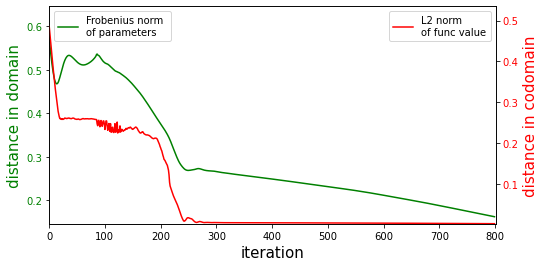

In [91]:
ana = post_analysis_single(stats)
ana.plot_distance()

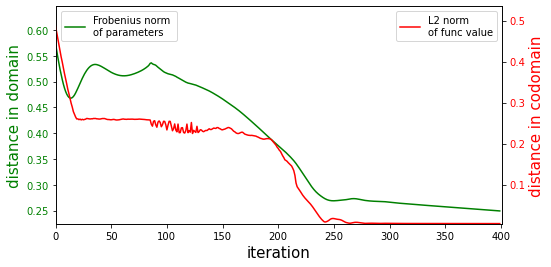

In [5]:
ana = post_analysis_single(stats)
ana.plot_distance()

(0.0, 0.5)

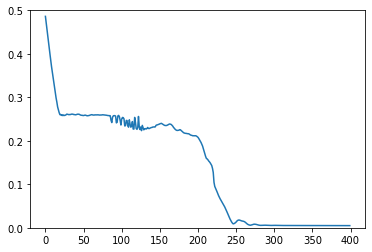

In [6]:
plt.plot(losses)
plt.ylim([0,0.5])

(0.0, 0.5)

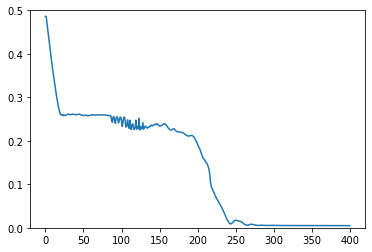

In [9]:
plt.plot(stats['val'])
plt.ylim([0,0.5])

In [8]:
final = torch.tensor(stats['arg'][-1], device=torch.device('cuda:0'))

In [11]:
final.requires_grad_(True)

tensor([[-0.1705, -0.3181,  0.0271, -0.1400, -0.0010,  0.1682, -0.1373,  0.0339]],
       device='cuda:0', requires_grad=True)

In [85]:
import plyfile
def write_verts_faces_to_file(verts, faces, ply_filename_out):

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(verts[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")

    ply_data = plyfile.PlyData([el_verts, el_faces])
    logging.debug("saving mesh to %s" % (ply_filename_out))
    ply_data.write(ply_filename_out)

In [86]:
N_MARCHING_CUBE = 64
verts, faces = mesh.create_mesh_optim(decoder, final, N=N_MARCHING_CUBE, max_batch=int(2 ** 18))
write_verts_faces_to_file(verts, faces, "data/final.ply")

In [4]:
final1 = torch.tensor([[-0.1002, -0.3736,  0.1695,  0.1200,  0.1178,  0.1962,  0.1246, -0.0640]])
final2 = torch.tensor([[-0.0935, -0.3092,  0.1673,  0.1764,  0.0734,  0.2136,  0.1456, -0.0942]])

In [6]:
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)

In [8]:
torch.norm(final2 - latent_target.cpu())

tensor(0.0869)

In [9]:
torch.norm(final1 - latent_target.cpu())

tensor(0.1626)

In [8]:
latent_target

tensor([[-0.0562, -0.2882,  0.1230,  0.2264,  0.0941,  0.1983,  0.1402, -0.1180]],
       device='cuda:0')

In [154]:
latent

tensor([[-0.3412, -0.4759, -0.1524,  0.0231,  0.1486,  0.3323, -0.1601, -0.1239]],
       device='cuda:0', requires_grad=True)

In [4]:
min(stats['val'])

0.004978255368769169

In [159]:
min(losses)

array(0.10836774, dtype=float32)

(0.0, 0.5)

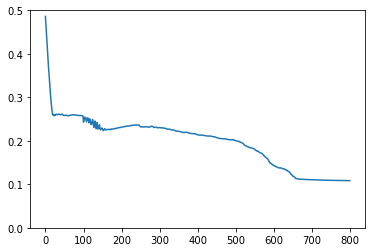

In [160]:
plt.plot(losses)
plt.ylim([0,0.5])

In [6]:
np.log(8)

2.0794415416798357

In [3]:
class cma_es(adjust_optimizer):
    def __init__(self, dim=2):
        self.dim = dim
        paras = {'x0': torch.zeros((dim,)),
                 'std': torch.ones((dim,)) * 3, 
                 'tol': 1e-5, 
                 'adjust_func': do_nothing(), 
                 'record': False, 
                 'verbose': False}
        self.set_parameters(paras)
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400 if 'max_iter' not in paras.keys() else paras['max_iter']
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'record' not in paras.keys() else paras['record']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
    def optimise(self, obj):
        '''
        @param obj: objective function class instance
        return arg: found minimum arguments
               val: found minimum value
               stats: collection of recorded statistics for post-analysis
        '''                  
        def update_mean(x):
            return (weights @ x).reshape(dim, 1)
        def update_ps(ps, sigma, C, mean, mean_old):
            return (1 - cs) * ps + torch.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
        def update_pc(pc, sigma, ps, mean, mean_old):
            hsig = (torch.norm(ps) / torch.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)).int()
            return (1 - cc) * pc + hsig * torch.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
        def update_C(C, pc, x, mean_old, sigma):
            hsig = (torch.norm(ps) / torch.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < (1.4 + 2/(dim + 1))).int()
            artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
            return (1 - c1 - cmu) * C + c1 * (pc * pc.transpose(1,0) + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.transpose(1,0) @ torch.diag(weights) @ artmp
        def update_sigma(sigma, ps):
            return sigma * torch.exp((cs / damps) * (torch.norm(ps)/ chiN - 1))
        def is_not_moving(arg, val, pre_arg, pre_val, tol):
            dis_arg = torch.norm(arg - pre_arg, dim=1).mean()
            dis_val = torch.abs(val - pre_val).mean()
            return (dis_arg < tol and dis_val < tol) 

        if self.verbose:
            print("\n\n*******starting optimisation from intitial mean: ", self.x0.squeeze().detach().cpu().numpy())
        # User defined input parameters 
        dim = self.dim
        sigma = 0.3
        D = self.std / sigma
        mean = self.x0.reshape(dim, 1)
        # the size of solutions group
        lambda_ = 4 + int(3 * np.log(dim)) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        mu = int(lambda_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        weights = np.log(mu + 1/2) - torch.log(torch.arange(mu, dtype=torch.float) + 1) 
        weights = (weights / torch.sum(weights)).cuda()   
        mueff = 1 / torch.sum(weights**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  
        # t-const for cumulation for sigma control
        cs = (mueff + 2) / (dim + mueff + 5)  
        # learning rate for rank-one update of C
        c1 = 2 / ((dim + 1.3)**2 + mueff)    
        # and for rank-mu update
        cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  
        # damping for sigma, usually close to 1  
        damps = 1 + 2 * max(0, torch.sqrt((mueff - 1)/( dim + 1)) - 1) + cs                                                                 

        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        pc = torch.zeros((dim, 1), device=torch.device('cuda:0'))     
        ps = torch.zeros((dim, 1), device=torch.device('cuda:0')) 
        # B defines the coordinate system
        B = torch.eye(int(dim), device=torch.device('cuda:0'))       
        # covariance matrix C
        C = B * torch.diag(D**2) * B.transpose(1, 0)
        # C^-1/2 
        invsqrtC = B * torch.diag(D**-1) * B.transpose(1, 0)
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  

        # --------------------  Initialization --------------------------------  
        x, x_old, f = torch.zeros((lambda_, dim), device=torch.device('cuda:0')),  \
                        torch.zeros((lambda_, dim), device=torch.device('cuda:0')), \
                        torch.zeros((lambda_,), device=torch.device('cuda:0'))
        stats = {}
        inner_stats = {}
        stats['inner'] = []
        stats['val'], stats['arg'] = [], []
        stats['x_adjust'] = []
        iter_eval, stats['evals_per_iter'] = torch.zeros((lambda_,)), []
        inner_stats = [{}] * lambda_
        stats['mean'], stats['std'] = [], []
        stats['status'] = None
        iter_, eval_ = 0, 0
        # initial data in record
        for i in range(lambda_):
            x[i,:] = (mean + 0.1 * torch.randn(dim, 1).cuda()).squeeze()
            #f[i] = obj.func(x[i])
            f[i] = torch.tensor([10])
        idx = torch.argsort(f.detach())
        x_ascending = x[idx]
        if self.record:
            stats['inner'].append(inner_stats.detach().numpy())
            stats['arg'].append(x_ascending.detach().numpy())
            stats['val'].append(f[idx].detach().numpy())
            stats['mean'].append(mean.detach().numpy())
            stats['std'].append(sigma * B @ torch.diag(D))
            stats['evals_per_iter'].append(torch.ones((lambda_,)).detach().numpy())
            stats['x_adjust'].append(np.vstack((x.T.clone().detach().numpy(), x.T.clone().detach().numpy())))
        arg = x_ascending
        val = f[idx]
        pre_arg = x_ascending
        pre_val = f[idx]
        best_val = 1e4
        best_arg = None
        
        # optimise by iterations
        try:
            while iter_ < self.max_iter:
                iter_ += 1
                # generate candidate solutions with some stochastic elements
                for i in range(lambda_):
                    x[i] = (mean + sigma * B @ torch.diag(D) @ torch.randn(dim, 1).cuda()).squeeze()
                    x_old[i] = x[i]
                    print("candidate: ", x[i])
                    x[i], f[i], inner_stats[i] = self.adjust_func.adjust(x[i].detach().requires_grad_(True), obj)
                    eval_ += inner_stats[i]['evals']
                    iter_eval[i] = inner_stats[i]['evals']
                # sort the value and positions of solutions 
                idx = torch.argsort(f.detach())
                x_ascending = x[idx]

                # update the parameter for next iteration
                mean_old = mean
                mean = update_mean(x_ascending[:mu])
                ps =   update_ps(ps, sigma, C, mean, mean_old)
                pc =   update_pc(pc, sigma, ps, mean, mean_old)
                sigma = update_sigma(sigma, ps)
                C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
                C = torch.triu(C) + torch.triu(C, 1).transpose(1,0)
                D, B = torch.eig(C, eigenvectors=True)
                D = torch.sqrt(D[:,0])
                invsqrtC = B @ torch.diag(D**-1) @ B.transpose(1,0)
                arg = x_ascending
                val = f[idx]
                if self.verbose:
                    print("iter: ", iter_)
                    print("loss: ", val[0].item())
                    print("latent: ", x_ascending[0].detach().cpu().numpy())
                    #print("mean: ", mean)
                    #print("sigma: ", sigma)
                    #print("std: ", D)
                    print("\n")
                # record data during process for post analysis
                if self.record:
                    stats['inner'].append(inner_stats.clone().detach().numpy())
                    stats['arg'].append(x_ascending.detach().numpy())
                    stats['val'].append(f[idx].detach().numpy())
                    stats['mean'].append(mean.detach().numpy())
                    stats['std'].append((sigma * B @ np.diag(D)).detach().numpy())
                    stats['evals_per_iter'].append(iter_eval.clone().detach().numpy())
                    stats['x_adjust'].append(np.vstack((x_old.T.clone().detach().numpy(), x.T.clone().detach().numpy())))
                # stopping condition  
                if best_val > val[0]:
                    best_val = val[0]
                    best_arg = arg[0]              
                # check the stop condition
                if torch.max(D) > (torch.min(D) * 1e6):
                    stats['status'] = 'diverge'
                    print('diverge, concentrate in low dimension manifold')
                    break
                if is_not_moving(arg, val, pre_arg, pre_val, self.tol) :
                    break
                pre_arg = arg
                pre_val = val
        except np.linalg.LinAlgError as err:
            stats['status'] = 'diverge'
            print('diverge, raise LinAlgError!')
        finally:
            if self.verbose:
                print('eigenvalue of variance = {}'.format(D))
                print('total iterations = {}, total evaluatios = {}'.format(iter_, eval_))
                print('found minimum position = {}, found minimum = {}'.format(best_arg.detach().numpy(), best_val.detach().numpy()))

        # carry statistics info before quit
        if self.record:
            stats['arg'] = np.array(stats['arg'])
            stats['val'] = np.array(stats['val'])
            stats['mean'] = np.array(stats['mean'])
            stats['std'] = np.array(stats['std'])
            stats['evals_per_iter'] = np.array(stats['evals_per_iter'])
            stats['x_adjust'] = np.array(stats['x_adjust'])
        stats['evals'] = eval_
        return best_arg, best_val, stats

In [73]:
cl = [[5.0, 2.0], [3.0, 9.0]]

In [62]:
C = torch.tensor(cl, device=torch.device('cuda:0')) # 

In [63]:
torch.triu(C, 1).transpose(1,0)

tensor([[0., 0.],
        [2., 0.]], device='cuda:0')

In [64]:
D, B = torch.eig(C, eigenvectors=True)

tensor([[ 2.7574,  0.0000],
        [11.2426,  0.0000]], device='cuda:0')

In [50]:
D, B = torch.eig(C, eigenvectors=True)
D = torch.sqrt(D[:,0])
#invsqrtC = B @ torch.diag(D**-1) @ B

In [66]:
B@torch.diag(D[:,0])@B.transpose(1,0)

tensor([[ 2.2680,  1.8969],
        [ 1.8969, 11.7320]], device='cuda:0')

In [58]:
B@torch.diag(D[:,0])@B

tensor([[ 2.1213,  4.9497],
        [-4.9497,  7.7782]], device='cuda:0')

In [77]:
CN = np.array(cl)
DN, BN, vh = np.linalg.svd(CN)

In [75]:
BN@np.diag(DN)@BN.T

array([[4.19512195, 1.75609756],
       [1.75609756, 9.80487805]])

In [81]:
DN.dot(np.diag(BN)).dot(vh)

array([[5., 2.],
       [3., 9.]])

In [87]:
BN**-1

array([0.09785314, 0.26203581])

In [94]:
torch.manual_seed(0)
# 0 Initialization
N_MARCHING_CUBE = 64
lr= 8e-3
l2reg= True
regl2 = 1e-3
decreased_by = 1.5
adjust_lr_every = 50

# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)

# 2 prepare model
decoder = constructDecoder(args)

In [ ]:
torch.manual_seed(0)
l2reg= True
# 1 prepare data
## sphere
source_id = 999 # zywvjkvz2492e6xpq4hd1jzy2r9lht        # This will be the source shape (ie starting point)
## torus
target_id = 2 # 0bucd9ryckhaqtqvbiagilujeqzek4  
latent, latent_target = getLatentSourceAndTarget(args, source_id, target_id)


# 2 prepare model
decoder = constructDecoder(args)

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
objectiveDe = decoder_obj(latent_target, decoder)
exp.set_objective(objectiveDe)
opt = cma_es(dim=8)
optParas ={'x0': latent,
           'std': torch.ones((8,), device=torch.device('cuda:0')) * 0.03, 
           'tol': 1e-3, 
           'adjust_func': do_nothing(), 
           'record': False, 
           'cluster_size': 10,
           'verbose': True}
opt.set_parameters(optParas)
exp.set_optimizer(opt)
exp.do()

In [15]:
torch.cuda.empty_cache() 

In [16]:
torch.cuda.memory_summary(device=None, abbreviated=False)

AttributeError: module 'torch.cuda' has no attribute 'memory_summary'

In [7]:
import gc
gc.collect()

22

In [12]:
torch.eig(a, eigenvectors=True)

torch.return_types.eig(
eigenvalues=tensor([[16.6566,  0.0000],
        [ 2.8434,  0.0000]]),
eigenvectors=tensor([[ 0.3133, -0.2781],
        [ 0.9497,  0.9605]]))

In [10]:
a = torch.tensor([[10.2, 2.13], [22.3, 9.3]])